## Autoencoder for Image Dataset (CAMVID)

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!curl -s https://course.fast.ai/setup/colab | bash #I am using colab, hence this line 

Updating fastai...
Done.


In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [4]:
path = untar_data(URLs.CAMVID)

In [5]:
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

## Data

In [6]:
fnames = get_image_files(path/'images')
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0006R0_f02730.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08085.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08105.png')]

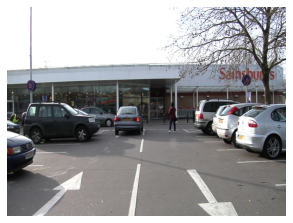

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
def get_y_fn(x): return x

In [9]:
mask = open_mask(get_y_fn(img_f))
src_size = np.array(mask.shape[1:])
src_size

array([720, 960])

## Datasets

In [0]:
bs,size = 4,src_size//2

In [0]:
src = (ImageImageList.from_folder(path/'images').split_by_rand_pct(seed=2).label_from_func(get_y_fn))
# the above line has been changed 

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

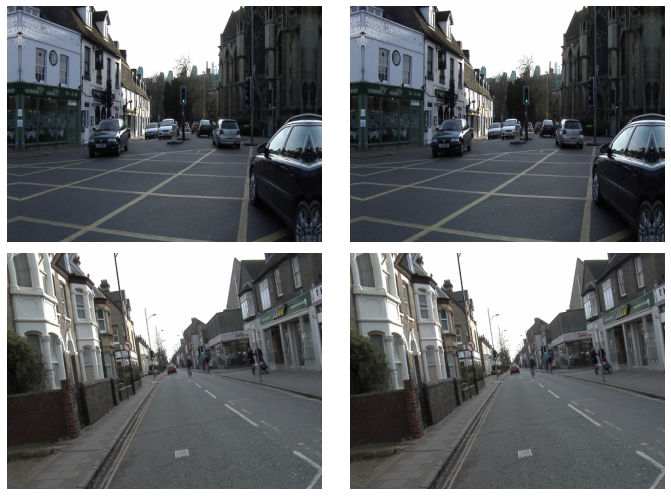

In [13]:
data.show_batch(2, figsize=(10,7))

## Model

In [0]:
metrics=mean_absolute_error #here you can use MSE as well, but since we are already printing it in validation loss, I used MAE 
wd=1e-2

In [15]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
import torch.nn as nn
learn.loss_func = nn.MSELoss() # this is also added. as we need to regress the pixel values for images 

epoch,train_loss,valid_loss,mean_absolute_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


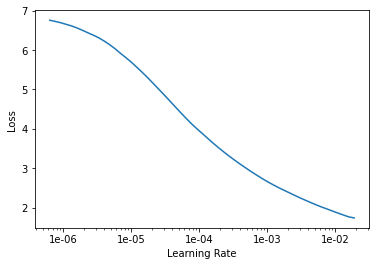

In [17]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=2e-3

In [19]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.060452,0.027440,0.118230,02:47
1,0.011481,0.004980,0.047587,02:46
2,0.002853,0.001382,0.025437,02:46
3,0.001507,0.000836,0.020794,02:45
4,0.000757,0.000509,0.016071,02:45
5,0.000413,0.000538,0.016737,02:45
6,0.000299,0.000166,0.008939,02:45
7,0.000249,0.001055,0.025992,02:45
8,0.000114,0.000040,0.003782,02:44
9,0.000037,0.000030,0.003037,02:44


In [0]:
learn.save('stage-1')

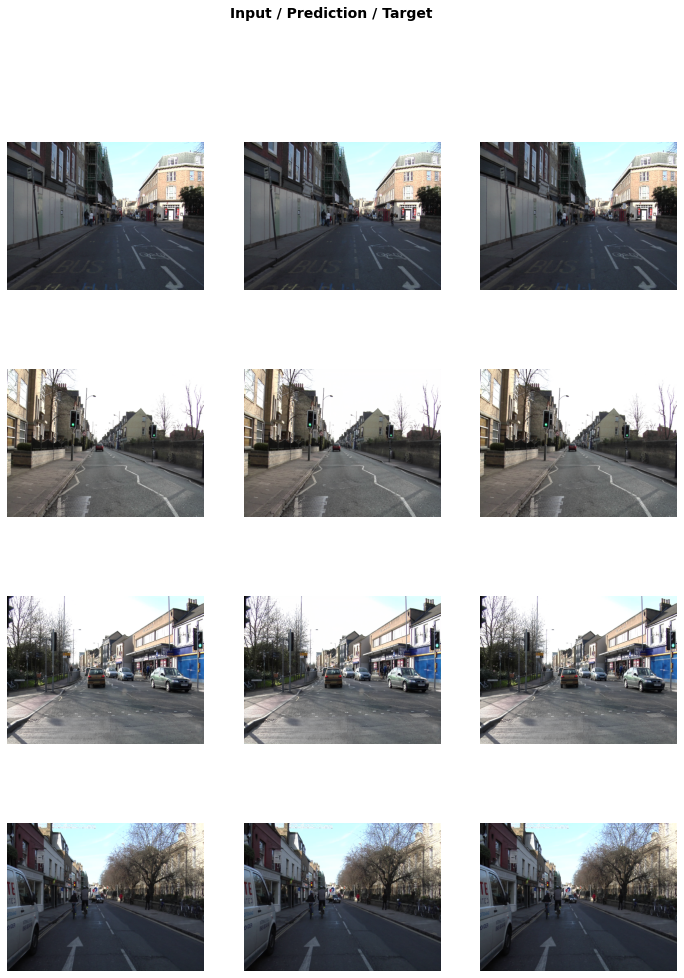

In [21]:
learn.load('stage-1');learn.show_results() #here all three are same as we want to predict the exact same thing as input 
# the more similar the input and the predictions are the better (the results seems to be awesome in this case)

In [0]:
def show_results(learn,figsize=(10,10)):

    inputs,classes = next(iter(learn.data.valid_dl))
    learn.model.train()
    preds = learn.model(inputs)
    stds = np.array([0.229, 0.224, 0.225])
    means = np.array([0.485, 0.456, 0.406])
    #inp = (inputs[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255
    target = (classes[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*128
    pred = (preds[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*128

    mse = np.sum(((pred - target)**2))/(pred.shape[0]*pred.shape[1]*pred.shape[2])
    psnr = 10*np.log10(255/mse)

    print('MSE:',mse)
    print('PSNR:', psnr)

    #import pdb;pdb.set_trace()
    print(np.min(target),np.max(target))

    fig = plt.figure(figsize=figsize)
    #ax0 = fig.add_subplot(131)
    #ax0.imshow(inp.astype(np.uint8))
    #ax0.title.set_text('Input')
    ax1 = fig.add_subplot(132)
    ax1.imshow(target.astype(np.uint8))
    ax1.title.set_text('Target')
    ax2 = fig.add_subplot(133)
    ax2.imshow(pred.astype(np.uint8))
    ax2.title.set_text('Prediction')

In [0]:
inputs,classes = next(iter(learn.data.valid_dl))
learn.model.eval()
preds = learn.model(inputs)

In [27]:
preds.shape

torch.Size([4, 3, 360, 480])

In [29]:
pred = preds[0]
pred.min()

tensor(-0.0187, device='cuda:0', grad_fn=<MinBackward1>)

In [41]:
data.train_ds.c

3

In [0]:
learn.show_results??

MSE: 0.02296237947849211
PSNR: 40.45523290574121
52.27429670917988 91.392


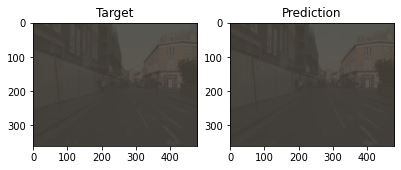

In [35]:
show_results(learn)

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/100,lr)

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.000195,0.000165,0.008190,01:23
1,0.000149,0.000121,0.006988,01:23
2,0.000141,0.000136,0.008722,01:23
3,0.000136,0.000102,0.007408,01:23
4,0.000333,0.000176,0.009777,01:24
5,0.000371,0.000287,0.011922,01:22
6,0.000298,0.000078,0.006038,01:22
7,0.000294,0.000108,0.006988,01:22
8,0.000612,0.000162,0.008620,01:22
9,0.000238,0.000131,0.007280,01:20


In [0]:
learn.save('stage-2')

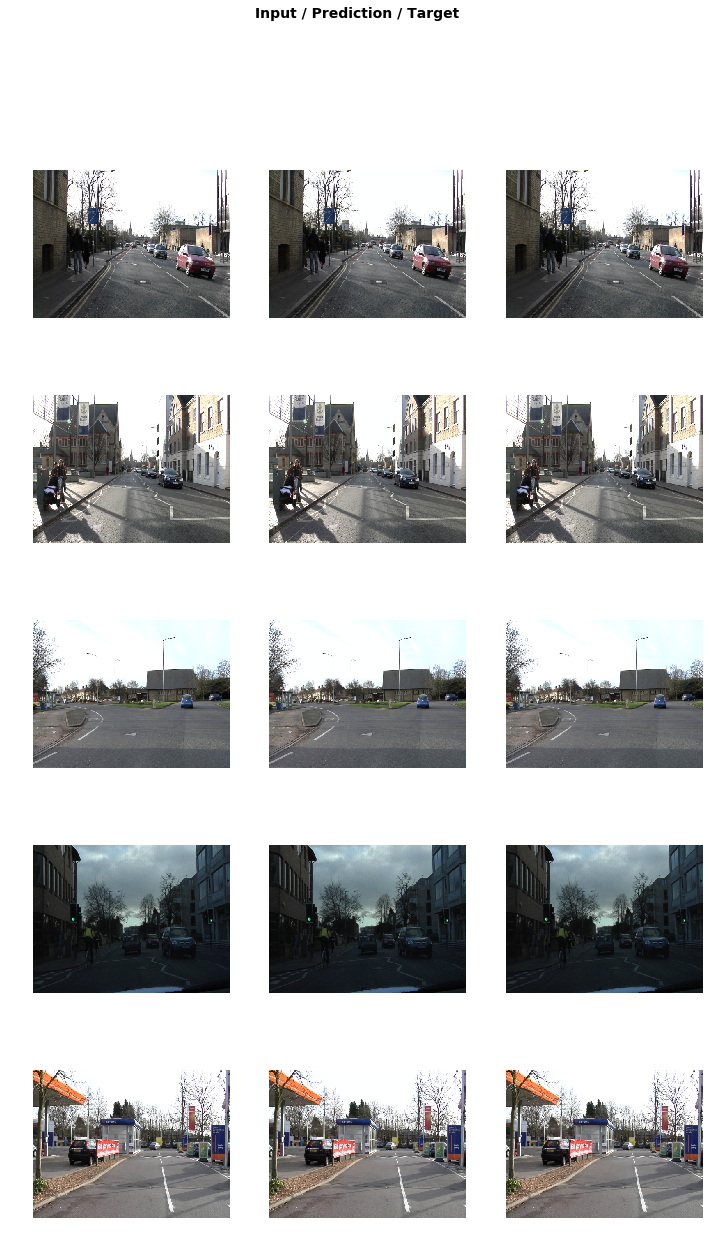

In [0]:
learn.show_results()

## Go big (this part has been trianed on smaller CAMVID tiny dataset)
This is due to memory restrictions on colab, I wasn't able to use CAMVID dataset for full sized training

In [0]:
learn=None
gc.collect()

49756

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [0]:
size = src_size
bs=4

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load('stage-2');

In [0]:
import torch.nn as nn
learn.loss_func = nn.MSELoss()

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.002824,0.002556,0.036107,00:02
1,0.002556,0.002332,0.033685,00:01
2,0.002233,0.001908,0.030457,00:01
3,0.001953,0.001456,0.026881,00:01
4,0.001773,0.001640,0.029184,00:01
5,0.001589,0.001375,0.026674,00:01
6,0.001400,0.000843,0.019702,00:01
7,0.001255,0.000721,0.018353,00:01
8,0.001106,0.000653,0.017760,00:01
9,0.000977,0.000634,0.017077,00:01


In [0]:
learn.save('stage-1-big')

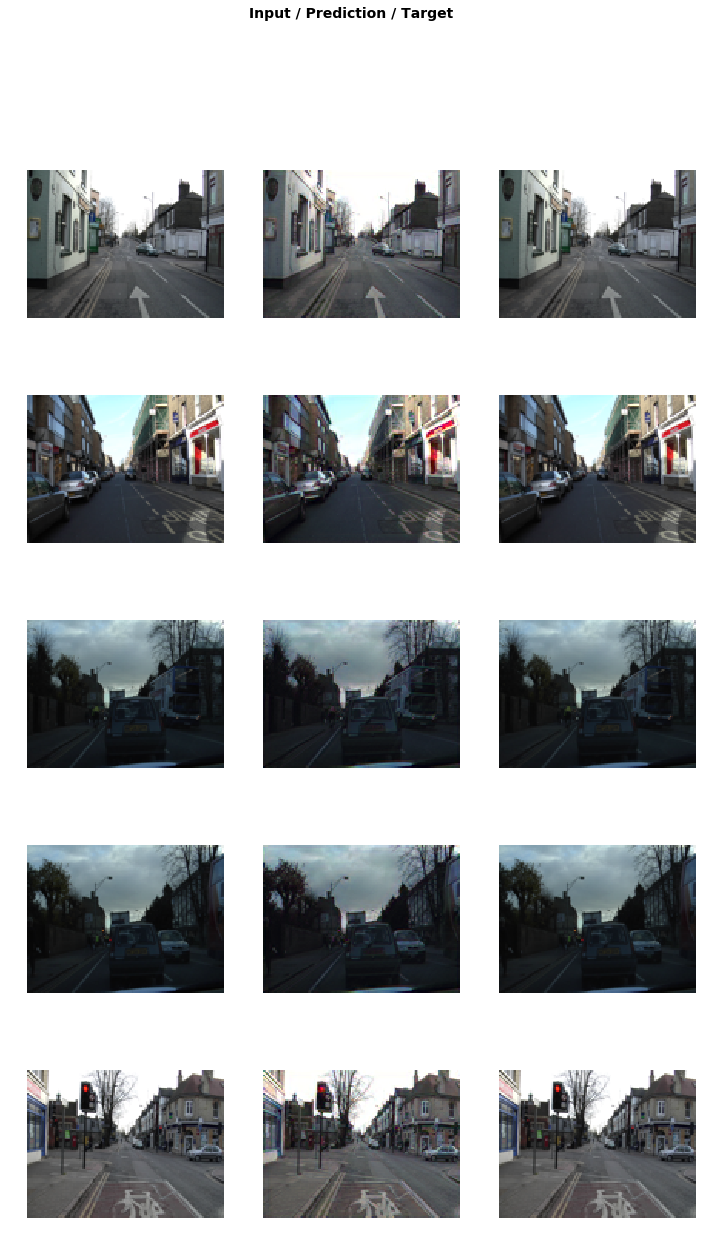

In [0]:
learn.load('stage-1-big');learn.show_results()

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/1000,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.000450,0.000570,0.015632,00:01
1,0.000438,0.000583,0.015646,00:01
2,0.000423,0.000584,0.016080,00:01
3,0.000413,0.000583,0.016194,00:01
4,0.000405,0.000529,0.014906,00:01
5,0.000395,0.000517,0.014676,00:01
6,0.000384,0.000497,0.014556,00:01
7,0.000379,0.000499,0.014383,00:01
8,0.000373,0.000502,0.014440,00:01
9,0.000367,0.000497,0.014334,00:01


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

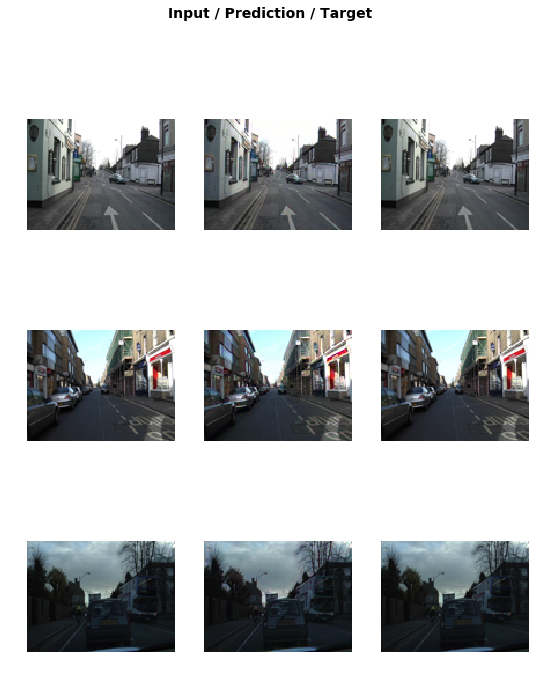

In [0]:
learn.show_results(rows=3, figsize=(9,11))